# Problem Description: 
**Build a CNN to classify properties damaged by hurricanes**

# Load data 
**DATA DESCRIPTION**
* The data is provided to you has the following subfolders:

    * train_another: the training data; 5000 images of each class(damage/no damage)
    * validation_another: the validation data; 1000 images of each class(damage/no damage)
    * test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes
    * test: the balanced test data; 1000 images of each class(damage/no damage)

# References and Resources 
* Deepsense AI blog : [ https://deepsense.ai/satellite-images-semantic-segmentation-with-deep-learning/ ]
* Ship detection in Sattelite Images: [ https://medium.com/intel-software-innovators/ship-detection-in-satellite-images-from-scratch-849ccfcc3072 ]
* Hurricane roof damage : [ https://www.restoremastersllc.com/wind-damage-roof/ ]
* Blog : [ https://www.nature.com/articles/s41524-021-00620-7 ]
* extra data : [ https://www.maxar.com/open-data/hurricane-delta ]
* cutmix :  https://medium.com/depurr/cutmix-augmentation-in-python-bf099a97afac
* cutmix :https://arxiv.org/abs/1905.04899
* Augmentation : https://wandb.ai/authors/tfaugmentation/reports/Modern-Data-Augmentation-Techniques-for-Computer-Vision--VmlldzoxODA3NTQ
* blog : https://omdena.com/blog/rooftops-classification/


In [1]:
# !pip install cutmix-keras -q

In [2]:
!pip install gdown -q

# Imports

In [3]:
#general imports 
import os 
import shutil
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import random
from IPython import display
import pickle

import multiprocessing as mp
# mapping 
import folium
from folium.plugins import MarkerCluster,HeatMap

#deep learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,Dense,MaxPooling2D,GaussianNoise,Flatten,Input,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

#backend
from tensorflow.keras import backend as K

#cutmix aug
# from cutmix_keras import CutMixImageDataGenerator


import warnings 
warnings.filterwarnings('ignore')

In [4]:

seed=7

def set_seed(seed):
    
    '''set seed for reproducablity'''
    os.environ['PYTHONHASHSEED']= str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(seed)    


# **Download and unzip**

In [5]:
if not os.path.exists('./input_data'):
    os.mkdir('./input_data')

#download unzip
!gdown https://drive.google.com/uc?id=1EH3p84xKMs_2m4ISSR7aHOQz61yxIv8L
!unzip ./Post-hurricane.zip -d ./input_data

# clear output
display.clear_output()

In [6]:
BATCH= 128 
img_size = (128,128)

In [7]:
def get_img_coordinates(row):
    path = row['paths']
    # get coordinates of images 
    #split the name
    
    img_id=path.split('/')[-1]
    
    lat,tmp = img_id.split('_')
    
    long = '.'.join(tmp.split('.')[:-1])
    
    row['lat']=float(lat)
    row['long']=float(long)
    row['geometry']=(float(long),float(lat))
    
    
    return row
    
def get_paths(data_dir):
    
    sub_dir = ['damage','no_damage']
    paths,damage,no_damage=[],0,0

    for i,path in enumerate(os.listdir(os.path.join(data_dir,'damage'))):
        paths.append(path) 
        damage += 1
       
    
    for i,path in enumerate(os.listdir(os.path.join(data_dir,'no_damage'))):
        paths.append(path) 
        no_damage += 1
        
    df = pd.DataFrame({'paths':paths})
    
    df.loc[:damage,'damage'] = 1
    df.loc[damage:,'no_damage'] = 1
    
    return df 



In [8]:

train_dir = './input_data/train_another'
test_dir = './input_data/test'
test_another = './input_data/train_another'
val_another = './input_data/validation_another'

In [9]:
#getting paths and coordinates 
train_csv = get_paths(data_dir = train_dir)
test_csv = get_paths(data_dir = test_dir)
test_an_csv = get_paths(data_dir = test_another)
val_csv = get_paths(data_dir = val_another)

train_csv=train_csv.apply(lambda x: get_img_coordinates(x),axis=1)
test_csv=test_csv.apply(lambda x: get_img_coordinates(x),axis=1)
test_an_csv=test_an_csv.apply(lambda x: get_img_coordinates(x),axis=1)
val_csv=val_csv.apply(lambda x: get_img_coordinates(x),axis=1)

# Visualizing Geographical Areas of Images

In [10]:


# lets see the points which are sensed in the study

def plot_heatmap(df_list,title,damage=1):
    
    loc = (df_list[0]['long'].mean(),df_list[0]['lat'].mean())
    
    m1=folium.Map(location=loc,
                  tiles='Open Street Map',
                  zoom_start=8,min_zoom=7)

    for df1 in df_list:
        if damage:
            data = df1[df1['damage']==1]['geometry']
        else:
            data =df1[df1['damage']!=1]['geometry']
        HeatMap(data=data,
                       radius=5,
                       opacity=0.5,
                       name='Damage').add_to(m1)

    
    print(f'{title} regions in picture')
    return m1


plot_heatmap(df_list=[train_csv,test_csv,test_an_csv,val_csv],title='Damaged')

Damaged regions in picture


In [11]:
plot_heatmap(df_list=[train_csv,test_csv,test_an_csv,val_csv],title='Not-damaged',damage=0)

Not-damaged regions in picture


# Image data generator

In [12]:
# loading data in image data generators

# train gen
train_gen = ImageDataGenerator( 
#     featurewise_center=False, #Set input mean to 0 over the dataset, feature-wise.
#     samplewise_center=False, # Set each sample mean to 0
#     featurewise_std_normalization=False, #Divide inputs by std of the dataset, feature-wise
    width_shift_range=(0.05,0.05), # (-width_shift_range, +width_shift_range)
    height_shift_range=(0.05,0.051),
    brightness_range=(0.6,1.2),
#     shear_range=1.2,
#     samplewise_std_normalization=False, # Divide each input by its std
    zca_whitening=False,  # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images.
#     zca_epsilon=1e-06,   
    rotation_range=180,    # degree range for randm rot
    zoom_range=(0.8,1.2),
    channel_shift_range=0.1,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255)

#val gen
val_gen = ImageDataGenerator(rescale=1/255)

In [13]:
# generating two data iterators for cutmix aug
train_data1= train_gen.flow_from_directory(train_dir,
                                           target_size = img_size,
                                           batch_size=BATCH,
                                           class_mode='binary',
                                           shuffle=True,
                                           seed=seed)

# train_data2= train_gen.flow_from_directory(train_dir,
#                                            target_size = img_size,
#                                            batch_size=BATCH,
#                                            class_mode='binary',
#                                            shuffle=True,
#                                            seed=seed)

#val data 
val_data = val_gen.flow_from_directory(val_another,
                                       target_size = img_size,
                                       batch_size=BATCH,
                                       class_mode='binary',
                                       shuffle=True,
                                       seed=seed)

#test data 
test_data = val_gen.flow_from_directory(test_dir,
                                       target_size = img_size,
                                       batch_size=BATCH,
                                       class_mode='binary',
                                       shuffle=True,
                                       seed=seed)
#unbalanced test data 
test_data_unbalanced = val_gen.flow_from_directory(test_another,
                                       target_size = img_size,
                                       batch_size=BATCH,
                                       class_mode='binary',
                                       shuffle=True,
                                       seed=seed)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


# Visualizing Images

In [14]:
def plot_image_grid(image_list,
                    label_list,
                    sample_images=False,
                    num_images=12,
                    pre_title='class',
                    num_img_per_row=3,
                    cmap=None,
                    img_h_w=3):
    '''viz images from a list of images and labels
    INPUTS:
    image_list: a list of images to be plotted,
    label_list: a list of correspomding image labels'''
    


    #number of img rows
    n_row= num_images//num_img_per_row

    plt.subplots(n_row,num_img_per_row,figsize=(img_h_w*num_img_per_row,img_h_w*n_row))

    if sample_images:
    #select_random images 
        sampled_ids = random.choices(np.arange(0,len(image_list)),k=num_images)

        for i,idx in enumerate(sampled_ids):

            img = image_list[idx]
            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)
    else:
        for i,img in enumerate(image_list):

            label = label_list[i]
            plt.subplot(n_row,num_img_per_row,i+1)
            plt.title(f'{pre_title} - {label}')
            plt.axis('off')
            plt.imshow(img,cmap=cmap)

            # break the loop 
            if i==num_images-1 :
                  break 

    #show
    plt.tight_layout()
    plt.show()


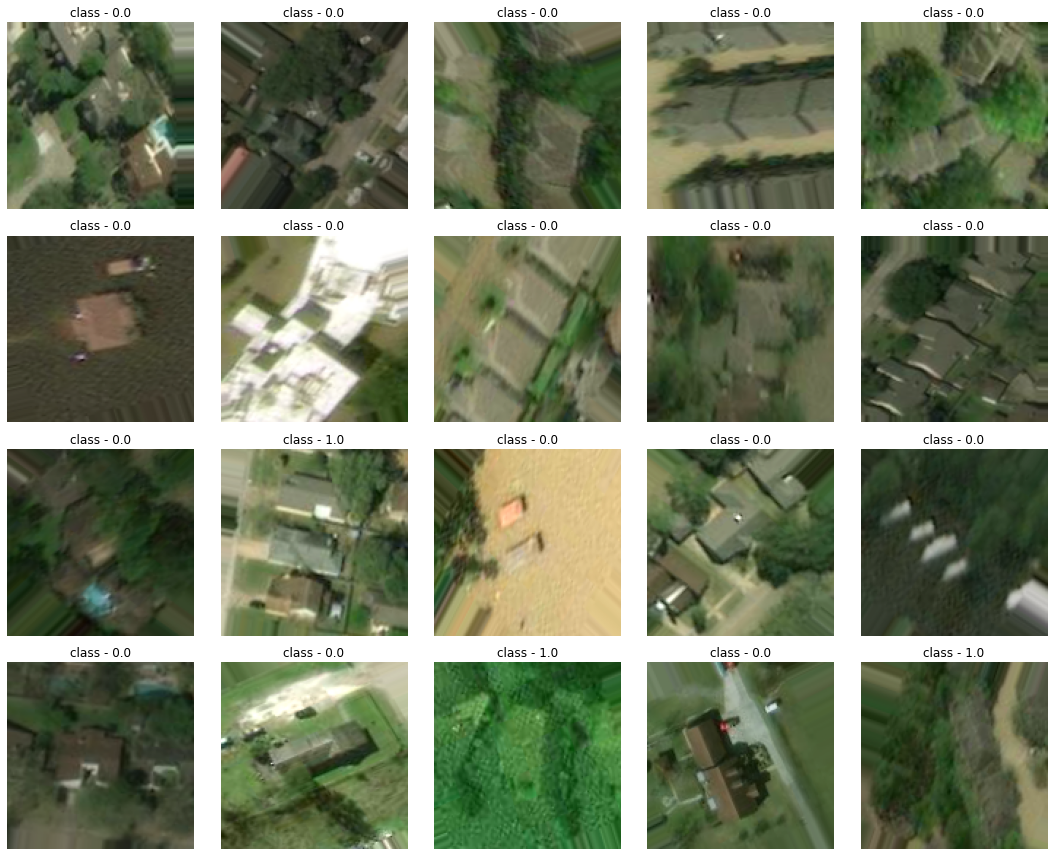

In [15]:
#select a batch for viewing test images 
image_list,label_list=train_data1.next()

plot_image_grid(image_list,
                label_list,
                sample_images=True,
                num_images=20,
               num_img_per_row=5)

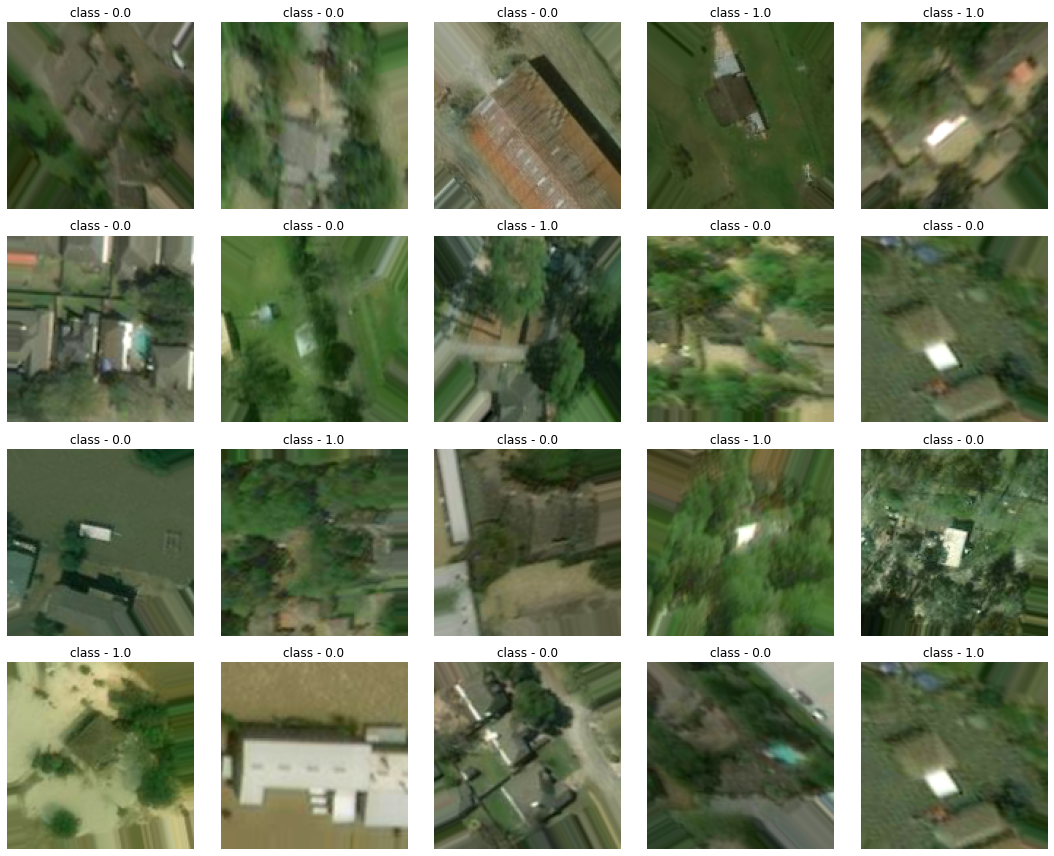

In [16]:
#select a batch for viewing test images 
image_list,label_list=train_data1.next()

plot_image_grid(image_list,
                label_list,
                sample_images=True,
                num_images=20,
               num_img_per_row=5)

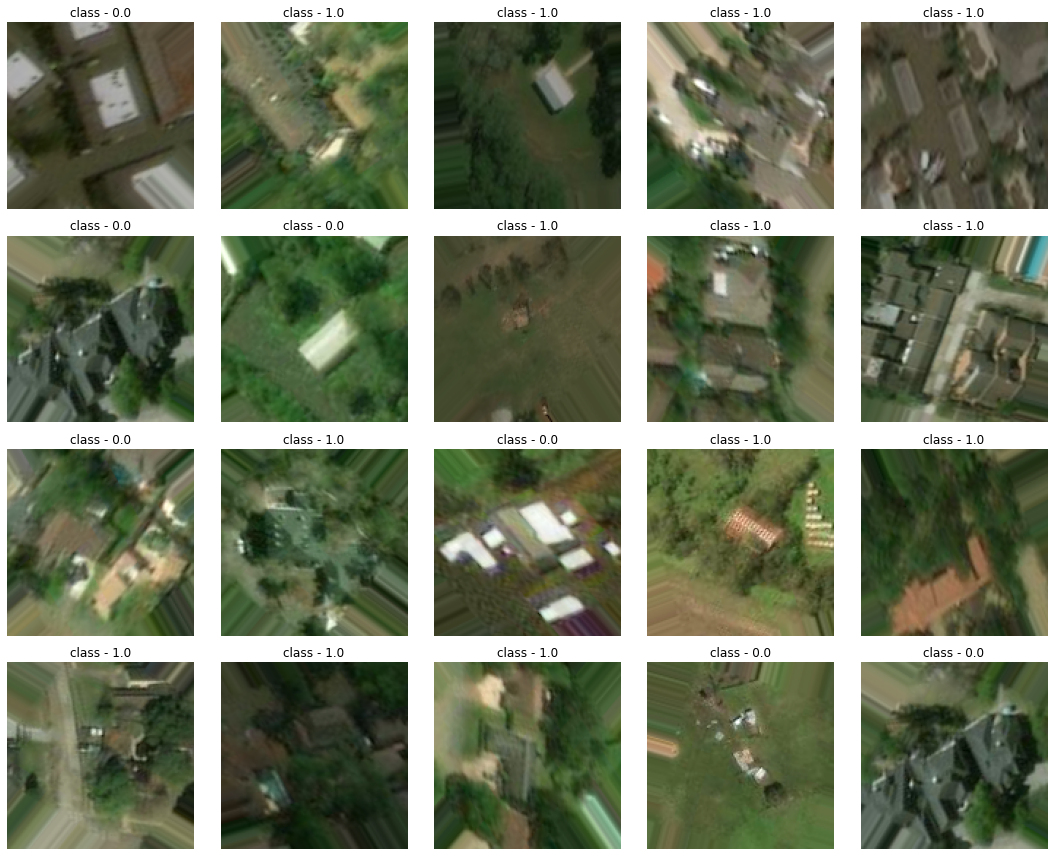

In [17]:
#select a batch for viewing test images 
image_list,label_list=train_data1.next()

plot_image_grid(image_list,
                label_list,
                sample_images=True,
                num_images=20,
               num_img_per_row=5)

# Generate a cutmix iterator

In [18]:
#from :  https://pypi.org/project/cutmix-keras/

# CutMixImageDataGenerator
# train_generator = CutMixImageDataGenerator(
#     generator1=train_data1,
#     generator2=train_data2,
#     img_size=img_size,
#     batch_size=BATCH,
# )


# Helper Functions

**Function for cutmix if using tfds**

In [19]:
# source : https://keras.io/examples/vision/cutmix/

# The CutMix function takes two image and label pairs to perform the augmentation. 
# It samples λ(l) from the Beta distribution and returns a bounding box from get_box function. 
# We then crop the second image (image2) and pad this image in the final padded image at the same location.


def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


# Build Model

In [20]:
# import pdb
class simple_cnn:
    def __init__(self):

        # layer regularization
        self.layer_reg ={'kernel_reg':{'l1':1e-5,
                                       'l2':1e-4},
                       'bias_reg': {'l1':1e-5,
                                   'l2':1e-4}
                        }


        # params for building model
        self.params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': self.layer_reg,           # layer regularization params
                  'drop'    :[0.6,0.5],             # dropout rates 
                  'kernel_size':[(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [8,16,32],             # conv layer number of filters * 2
                  'strides' : [1,1,1],
                  'activations': ['relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.1
                 }
        
    
    
    def build(self,
              input_shape,
              update_params,
              output_layer
             ):
        self.input_shape=input_shape
        
        self.output_params = output_layer
        #update params shape
        if update_params:
            self.params.update(update_params)
        '''
        build a CNN with given parameters
        -input_shape   :  input image shape (example: (256,256,3),
        - update_params: update build params
        - output_layer : output_layer_params , ex {'n_out':num_classes,'activation':'softmax'}
        
        
        # Build Params:
        
        n_dense : list of number of units in each dense layer
        activations: list of activation in each CONV layer  
        kernel_size:list of kernel size
        conv: list of number of conv filters
        pool_size: list of pooling size 
        layer_reg: dense layer regularization
        drop     : list of dropouts after dense layers
        compile_params: model compilation parameters ,
        gaussian_noise: add gaussian noise layer to the model with std of given value'''
           
        # input layer
        inp = Input(shape = self.input_shape)
        if self.params['gaussian_noise']:
          #add gaussian noise
            x = GaussianNoise(stddev=self.params['Gaussian_noise_std'])(inp)
            
            x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(x)
        
        else:
        
            x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(inp)
        
        x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(x)
        x = MaxPooling2D(pool_size=self.params['pool_size'][0],
                         strides =self.params['strides'][0])(x)
        
        if self.params['batch_norm']:
            x = BatchNormalization()(x)

        for i in range(1,len(self.params['conv'])):
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                       strides =self.params['strides'][i])(x)
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                      strides =self.params['strides'][i])(x)
            x = MaxPooling2D(pool_size=self.params['pool_size'][i],
                             strides =self.params['strides'][i])(x)
            
            if self.params['batch_norm']:
                x = BatchNormalization()(x)

        # 
        x = Flatten()(x)
        
        
#         pdb.set_trace()
        # regularization
        self.kernel_reg=regularizers.l1_l2(l1=self.params['layer_reg']['kernel_reg']['l1'],
                                           l2=self.params['layer_reg']['kernel_reg']['l2'])

        x = Dense(self.params['n_dense'][0],
                  activation=self.params['dense_act'][0],
                  kernel_regularizer=self.kernel_reg,
                  bias_regularizer = regularizers.l1_l2(
                      l1=self.params['layer_reg']['bias_reg']['l1'],
                      l2=self.params['layer_reg']['bias_reg']['l2']))(x)

        x = BatchNormalization()(x)
        x = Dropout(self.params['drop'][0])(x)

        if len(self.params['n_dense'])>1:
            for i in range(1,len(self.params['n_dense'])):
                x = Dense(self.params['n_dense'][i],
                          activation=self.params['dense_act'][i],
                          kernel_regularizer=self.kernel_reg,
                          bias_regularizer = regularizers.l1_l2(l1=self.params['layer_reg']['bias_reg']['l1'],
                                                                l2=self.params['layer_reg']['bias_reg']['l2']))(x)
                #drop
                x = BatchNormalization()(x)
                x = Dropout(self.params['drop'][i])(x)

        out = Dense(self.output_params['n_out'],
                    activation=self.output_params['activation'])(x)
        
        
        model = Model(inputs=[inp],outputs = out)
        return model 
    
# plot train and val acc as  a function of epochs
def plot_history(history,addn_metric=None,add_metric=None):
    '''
    Inputs
    history:history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)
    
    if addn_metric:
        plt.subplots(1,3,figsize=(20,6))
        
        #loss:
        ax1=plt.subplot(1,3,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,3,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

    
        
        ax3= plt.subplot(1,3,3)
        ax3.plot(range(len(his)),his[f'{add_metric}'],color='g',label='training')
        ax3.plot(range(len(his)),his[f'val_{add_metric}'],color='r',label='validation')
        ax3.set_xlabel('EPOCHS')
        ax3.set_ylabel(f'{add_metric}')
        ax3.legend()
        ax3.set_title(f'{add_metric} Per Epoch')

        
    else:
        plt.subplots(1,2,figsize=(20,8))
        
    
    
        #loss:
        ax1=plt.subplot(1,2,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,2,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

        
    
    
    plt.show()  


In [21]:
layer_reg ={'kernel_reg':{'l1':1e-4,'l2':1e-3},
            'bias_reg': {'l1':1e-4,
                         'l2':1e-3}}

params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': layer_reg,           # layer regularization params
                  'drop'    :[0.5,0.5],             # dropout rates after dense
                  'kernel_size':[(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [32,64],             # conv layer number of filters * 2
                  'strides' : [2,1,1],
                  'activations': ['relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.11
                 }

cnn_model = simple_cnn().build(input_shape=(img_size+ (3,)),
                               update_params=params,
                               output_layer={'n_out':1,
                                            'activation':'sigmoid'})

cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496 

2021-12-18 07:56:45.184220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:56:45.305189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:56:45.306244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:56:45.307775: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
# from tensorflow_addons.metrics import F1Score
#metrics for model evaluation:
# f1_score=F1Score(num_classes=1,average='macro',name='f1_score')

#from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Training

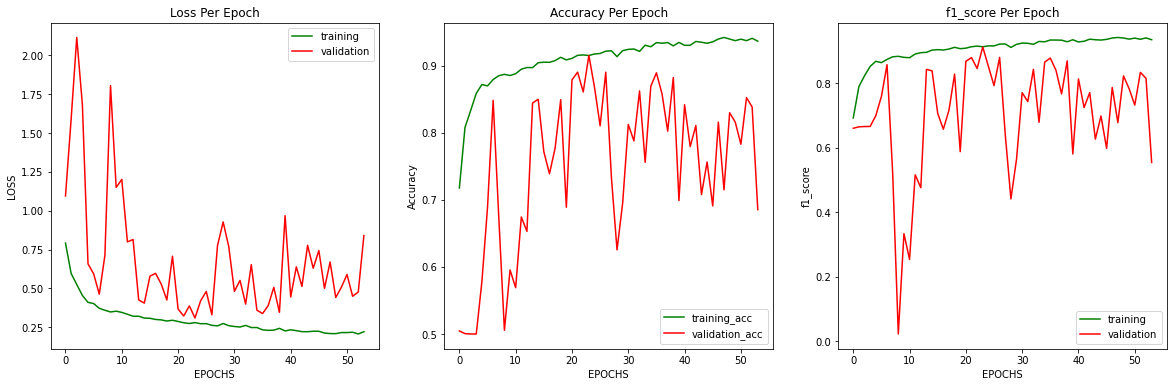

In [23]:
# compilation params
compile_params ={'loss':'binary_crossentropy',
                'metrics':['accuracy',f1_score,recall_m,precision_m],
                'optimizer':'adam'}

cnn_model.compile(**compile_params)


# callbacks 
#reduce_lr
reduce_lr=ReduceLROnPlateau(patience=10,
                            factor=0.9,
                            min_delta=1e-2,
                            monitor='val_f1_score',
                            verbose=1,
                            mode='max')

#early stopping
early_stopping=EarlyStopping(patience=30,
                             min_delta=1e-2,
                              monitor='val_f1_score',
                              restore_best_weights=True,
                              mode='max')

EPOCHS = 75

history = cnn_model.fit(train_data1,
                        validation_data=val_data,
                        steps_per_epoch=train_data1.n//BATCH,
                       epochs=EPOCHS,
                       callbacks = [reduce_lr,early_stopping],
                       verbose=1)

display.clear_output()

plot_history(history,addn_metric=True,add_metric='f1_score')

In [24]:
#saving custom metrics for loading later 
custom_metrics = {'recall_m':recall_m,
                 'precision_m':precision_m,
                 'f1_score': f1_score}

with open('f1_metrics.pkl','wb') as f:
    pickle.dump(custom_metrics,f)

**Saving model for future use**

In [25]:
models = 'saved_models'
os.mkdir(models)

cnn_model.save(filepath=os.path.join(models,'cnn_1.h5'))

# Evaluate on test data 

In [26]:
print('Evaluate on train set')
cnn_model.evaluate(train_data1)

Evaluate on train set
79/79 [==============================] - 56s 705ms/step - loss: 0.4182 - accuracy: 0.8246 - f1_score: 0.8470 - recall_m: 0.9740 - precision_m: 0.7502


[0.41821908950805664,
 0.8245999813079834,
 0.847011923789978,
 0.9739956259727478,
 0.7502179741859436]

In [27]:
print('Evaluate on val set')
cnn_model.evaluate(val_data)

Evaluate on val set
16/16 [==============================] - 2s 95ms/step - loss: 0.3104 - accuracy: 0.9155 - f1_score: 0.9140 - recall_m: 0.8979 - precision_m: 0.9323


[0.3103939890861511,
 0.9154999852180481,
 0.9139604568481445,
 0.8979291915893555,
 0.9322528839111328]

In [28]:
print('Evaluate on Balanced test set')
cnn_model.evaluate(test_data)

Evaluate on Balanced test set
16/16 [==============================] - 2s 97ms/step - loss: 0.3364 - accuracy: 0.8995 - f1_score: 0.8976 - recall_m: 0.8892 - precision_m: 0.9068


[0.3363535702228546,
 0.8995000123977661,
 0.897572934627533,
 0.8891897797584534,
 0.9068177938461304]

In [29]:
print('Evaluate on Un Balanced test set')
cnn_model.evaluate(test_data_unbalanced)

Evaluate on Un Balanced test set
79/79 [==============================] - 9s 107ms/step - loss: 0.3225 - accuracy: 0.9099 - f1_score: 0.9082 - recall_m: 0.9040 - precision_m: 0.9136


[0.32254117727279663,
 0.9099000096321106,
 0.9081851840019226,
 0.9039854407310486,
 0.9135874509811401]